In [2]:
import requests
import os
from tqdm import tqdm
import json
import re
import emoji
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
INPUT_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/raw'
PREPROCESSED_INPUT_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/preprocessed'
ANNOTATED_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/ann/raw'
CLEANED_INPUT_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/cleaned/threads'
CLEANED_ANNOTATED_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/cleaned/ann'
CLEANED_FIXED_ANNOTATED_FOLDER = '/home/burak/Desktop/IM/im/data/tw_data/PDTB_Annotations_20200205__/cleaned/fixed_ann'

In [12]:
def parse_file(file_path):
    files = {'input': open(file_path, 'rb')}

    r = requests.post('http://localhost:5500/parse', files=files)
    return r

def to_annotation_format(span_list):
    return ';'.join('..'.join(map(str, r)) for r in span_list)

def to_plain_result(result):
    arg1 = result['Arg1']['RawText']
    arg1_range = to_annotation_format(result['Arg1']['CharacterSpanList'])
    arg2 = result['Arg2']['RawText']
    arg2_range = to_annotation_format(result['Arg2']['CharacterSpanList'])
    connective = result['Connective']['RawText']
    connective_range = to_annotation_format(result['Connective']['CharacterSpanList'])
    sense = result['Sense']
    typ = result['Type']
    result_plain = {
        'arg1': arg1,
        'arg1_range': arg1_range,
        'arg2': arg2,
        'arg2_range': arg2_range,
        'connective': connective,
        'connective_range': connective_range,
        'sense': sense,
        'type': typ
    }
    return result_plain

def parse_result(file_name):
    result = json.loads(files_tweets[file_name])
    parsed_results = []
    for item in result:
        parsed_results.append(to_plain_result(item))
    return parsed_results

def parse_annotation_fixed(input_file_path, annotated_file_path, annotated_file_fixed_path):
    annotations = []
    with open(input_file_path, encoding="utf8") as input_file:
        with open(annotated_file_path) as ann_file:
            with open(annotated_file_fixed_path) as ann_file_fixed:
                file_content = input_file.read()
                fixed_lines = ann_file_fixed.readlines()
                for i, line in enumerate(ann_file):
                    fixed_line = fixed_lines[i]
                    fixed_properties = fixed_line.split('|')

                    properties = line.split('|')
                    typ = properties[0]
                    connective_ranges = None
                    connective = None
                    if typ == 'Explicit':
                        connective_ranges = properties[1]
                        connective = extract_from_ranges(file_content, fixed_properties[1])
                    if typ == 'Implicit':
                        connective_ranges = properties[31]
                    sense = properties[8]
                    arg1_range = properties[14]
                    arg2_range = properties[20]
                    arg1 = extract_from_ranges(file_content, fixed_properties[14])
                    arg2 = extract_from_ranges(file_content, fixed_properties[20])
                    result = {
                        'arg1_range': arg1_range,
                        'arg2_range': arg2_range,
                        'arg1': arg1,
                        'arg2': arg2,
                        'connective_range': connective_ranges,
                        'connective': connective,
                        'sense': sense,
                        'type': typ
                    }
                    annotations.append(result)
    return annotations

def parse_annotation(input_file_path, annotated_file_path):
    annotations = []
    with open(input_file_path, encoding="utf8") as input_file:
        with open(annotated_file_path) as ann_file:
                file_content = input_file.read()
                for line in ann_file:

                    properties = line.split('|')
                    typ = properties[0]
                    connective_ranges = None
                    connective = None
                    if typ == 'Explicit':
                        connective_ranges = properties[1]
                        connective = extract_from_ranges_16(file_content, connective_ranges)
                    if typ == 'Implicit':
                        connective_ranges = properties[31]
                    sense = properties[8]
                    arg1_range = properties[14]
                    arg2_range = properties[20]
                    arg1 = extract_from_ranges_16(file_content, arg1_range)
                    arg2 = extract_from_ranges_16(file_content, arg2_range)
                    result = {
                        'arg1_range': arg1_range,
                        'arg2_range': arg2_range,
                        'arg1': arg1,
                        'arg2': arg2,
                        'connective_range': connective_ranges,
                        'connective': connective,
                        'sense': sense,
                        'type': typ
                    }
                    annotations.append(result)
    return annotations

def is_unwanted(word):
    if is_handle(word):
        return True
    if is_url(word):
        return True
    return False

def is_handle(word):
    return word[0] == '@'

def is_url(word):
    return re.match(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', word)           
            
def extract_from_ranges_16(file_content, rangs):
    file_content = file_content.encode('utf-16le')
    text = []
    for rang in rangs.split(';'):
        if len(rang) < 2:
            return ''
        splitted = rang.split('..')
        word = file_content[int(splitted[0]) * 2: int(splitted[1]) * 2].decode('utf-16le')
        text.append(word)
    return ' '.join(text)

In [8]:
### get file names
files = os.listdir(INPUT_FOLDER)

In [7]:
### create a dict with. key: file names value: parsed tweets
files_tweets = dict()
for file in files:
    _parsed = parsed_tweets.get(file)
    if _parsed:
        files_tweets[file] = parsed_tweets[file]
    
with open('parsed_tweets_cleaned.json', 'w') as file:
    file.write(json.dumps(files_tweets))

NameError: name 'parsed_tweets' is not defined

In [13]:
### parse annotations into readable jsons
readable_annotations = dict()

for file in files:
    try:
        readable_annotations[file] = dict()
        for annotation in parse_annotation(
            CLEANED_INPUT_FOLDER + '/' + file,
            CLEANED_ANNOTATED_FOLDER + '/' + file
        ):
            _id = annotation['connective_range']
            readable_annotations[file][_id] = annotation
    except Exception as inst:
        print(file, type(inst))

with open('cleaned_annotations.json', 'w+', encoding='utf8') as new_file:
    new_file.write(json.dumps(readable_annotations))

093_950279658192347136.branch49.txt.username_text_tabseparated <class 'UnicodeDecodeError'>
095_950296746743169024.branch3.txt.username_text_tabseparated <class 'FileNotFoundError'>


In [9]:
### create cleaned plain relation objects
plain_parsed = dict()
errors = []
with open('parsed_tweets_cleaned.json', 'r') as new_file:
        obj = json.loads(new_file.read())
        for file in obj.keys():
            try:
                cur_parsed = dict()
                for output in json.loads(obj[file]):
                    result = to_plain_result(output)
                    cur_parsed[result['connective_range']] = result
                plain_parsed[file] = cur_parsed
            except Exception as err:
                errors.append(err)
                print('error for some reason!')

with open('cleaned_parsed_plain.json', 'w+', encoding='utf8') as new_file:
    new_file.write(json.dumps(plain_parsed))

error for some reason!


In [14]:
### read plain annotated relations from file

plain_annotated = None
with open('cleaned_annotations.json', 'r') as f:
    plain_annotated = json.loads(f.read())

plain_parsed = None
with open('cleaned_parsed_plain.json', 'r') as f:
    plain_parsed = json.loads(f.read())

# Evaluation

In [15]:
def calculate_metrics(y_true, y_pred, field_name, modifier = lambda x: x):
    y_true_field = [modifier(y[field_name]) for y in y_true]
    y_pred_field = [modifier(y[field_name]) for y in y_pred]
    return metrics.classification_report(y_true_field, y_pred_field, digits=3)

def compare_intervals(interval1, interval2):
    intervals1 = interval1.split(';')
    intervals2 = interval2.split(';')
    
    interval1_set = []
    interval2_set = []
    
    if len(intervals1) > 0 or intervals1[0] == '':
        for interval in intervals1:
            try:
                splitted_interval = interval.split('..')
                start = int(splitted_interval[0])
                end = int(splitted_interval[1])
                interval1_set.extend(range(start, end))
            except:
                a = 1
        
    if len(intervals2) > 0 or intervals2[0] == '':
        for interval in intervals2:
            try:
                splitted_interval = interval.split('..')
                start = int(splitted_interval[0])
                end = int(splitted_interval[1])
                interval2_set.extend(range(start, end))
            except:
                a = 1
        
    interval1_set = set(interval1_set)
    intersection = interval1_set.intersection(interval2_set)
    return len(interval1_set), len(interval2_set), len(intersection)
            

def evaluate(parsed, annotation):
    annotation_length = sum(len(v) for v in annotation.values())
    parsed_length = sum(len(v) for v in parsed.values())
    connective_match = 0
    sense1_match = 0
    sense2_match = 0
    type_match = 0
    arg1_match = 0
    arg2_match = 0
    arg1_total_parsed_length = 0
    arg1_total_annotated_length = 0
    arg2_total_parsed_length = 0
    arg2_total_annotated_length = 0
    arg1_intersection = 0
    arg2_intersection = 0
    pred = []
    treu = []
    results = []
    
    for p_file_key in parsed.keys():
        all_keys = np.concatenate((
            list(parsed[p_file_key].keys()) or [],
            list(annotation.get(p_file_key).keys()) or []
        ))
        for key in all_keys:
            cur_result = dict()
    
    for p_file_key in parsed.keys():
        for p_connective_key in parsed[p_file_key].keys():
            cur_ann = annotation.get(p_file_key)
            if not cur_ann:
                break
            if p_connective_key in cur_ann.keys():
                cur_result = dict()
                cur_result['file_key'] = p_file_key
                cur_result['connective_key'] = p_connective_key
                connective_match += 1
                cur_annotation_relation = cur_ann[p_connective_key]
                cur_parsed_relation = parsed[p_file_key][p_connective_key]
                pred.append(cur_parsed_relation)
                treu.append(cur_annotation_relation)
                # sense
                a_sense = cur_annotation_relation['sense'].split('.')
                p_sense = cur_parsed_relation['sense'].split('.')
                if a_sense[0] == p_sense[0]:
                    sense1_match += 1
                    if a_sense[1] == p_sense[1]:
                        sense2_match += 1
                cur_result['a_sense_1'] = a_sense[0]
                cur_result['p_sense_1'] = p_sense[0]
                cur_result['a_sense_2'] = '.'.join(a_sense[:2])
                cur_result['p_sense_2'] = '.'.join(p_sense[:2])
                cur_result['sense_1_match'] = a_sense[0] == p_sense[0]
                cur_result['sense_2_match'] = '.'.join(a_sense[:2]) == '.'.join(p_sense[:2])
                
                # type
                a_type = cur_annotation_relation['type']
                p_type = cur_parsed_relation['type']
                if a_type == p_type:
                    type_match += 1
                cur_result['a_type'] = a_type
                cur_result['p_type'] = p_type
                cur_result['type_match'] = a_type == p_type
                    
                # arg1
                a_arg1 = cur_annotation_relation['arg1_range']
                p_arg1 = cur_parsed_relation['arg1_range']
                ## exact match
                if a_arg1 == p_arg1:
                    arg1_match += 1
                ## partial match
                _a1, _p1, _i1 = compare_intervals(a_arg1, p_arg1)
                arg1_total_annotated_length += _a1
                arg1_total_parsed_length += _p1
                arg1_intersection += _i1
                
                cur_result['a_arg1_length'] = _a1
                cur_result['p_arg1_length'] = _p1
                cur_result['arg1_match'] = _i1
                    
                # arg2
                a_arg2 = cur_annotation_relation['arg2_range']
                p_arg2 = cur_parsed_relation['arg2_range']
                ## exact match
                if a_arg2 == p_arg2:
                    arg2_match += 1
                ## partial match
                _a2, _p2, _i2 = compare_intervals(a_arg2, p_arg2)
                arg2_total_annotated_length += _a2
                arg2_total_parsed_length += _p2
                arg2_intersection += _i2
                
                cur_result['a_arg2_length'] = _a2
                cur_result['p_arg2_length'] = _p2
                cur_result['arg2_match'] = _i2
                
                results.append(cur_result)
    
    result = ''                
    result += str(calculate_metrics(treu, pred, 'sense', lambda sense: sense.split('.')[0]))
    result += '\n'
    result += str(calculate_metrics(treu, pred, 'sense', lambda sense: '.'.join(sense.split('.')[:2])))
    result += '\n'
    result += str(calculate_metrics(treu, pred, 'type'))
    result += '\n'
                
    result += 'annotated relations: ' + str(annotation_length)
    result += '\n'
    result += 'parsed relations: ' + str(parsed_length)
    result += '\n'
    result += 'connective match: ' + str(connective_match)
    result += '\n'
    result += 'sense lvl1 match: ' + str(sense1_match)
    result += '\n'
    result += 'sense lvl2 match: ' + str(sense2_match)
    result += '\n'
    result += 'type match: ' + str(type_match)
    result += '\n'
    result += 'arg1 match: ' + str(arg1_match)
    result += '\n'
    result += 'arg2 match: ' + str(arg2_match)
    result += '\n'
    result += 'args partial match: '
    result += '\n'
    result += 'arg1 char match: ' + str(arg1_intersection)
    result += '\n'
    result += 'arg1 annotated total: ' + str(arg1_total_annotated_length)
    result += '\n'
    result += 'arg1 parsed total: ' + str(arg1_total_parsed_length)
    result += '\n'
    result += 'arg2 char match: ' + str(arg2_intersection)
    result += '\n'
    result += 'arg2 annotated total: ' + str(arg2_total_annotated_length)
    result += '\n'
    result += 'arg2 parsed total: ' + str(arg2_total_parsed_length)
    result += '\n'
    
    print(result)
    return results

def get_comparison_dict(parsed, annotation):
    results = []
    
    for p_file_key in parsed.keys():
        cur_p_file = parsed.get(p_file_key)
        cur_a_file = annotation.get(p_file_key)
        all_keys = np.concatenate((
            list(cur_p_file.keys()) if p_file_key in parsed.keys() else [], 
            list(cur_a_file.keys()) if p_file_key in annotation.keys() else []
        ))
        all_keys = np.unique(all_keys)
        for connective_key in all_keys:
            cur_result = dict()
            cur_result['file_key'] = p_file_key
            cur_result['connective_key'] = connective_key
            cur_result['a_exists'] = connective_key in cur_a_file if cur_a_file else False
            cur_result['p_exists'] = connective_key in cur_p_file if cur_p_file else False
            
            if cur_result['a_exists']:
                cur_a_relation = annotation[p_file_key][connective_key]
                
                a_sense = cur_a_relation['sense'].split('.')
                cur_result['a_sense_1'] = a_sense[0]
                cur_result['a_sense_2'] = '.'.join(a_sense[:2])
                
                a_type = cur_a_relation['type']
                cur_result['a_type'] = a_type
                
                a_arg1 = cur_a_relation['arg1_range']
                cur_result['a_arg1_range'] = a_arg1
                
                a_arg2 = cur_a_relation['arg2_range']
                cur_result['a_arg2_range'] = a_arg2
                
            if cur_result['p_exists']:
                cur_p_relation = parsed[p_file_key][connective_key]
                
                p_sense = cur_p_relation['sense'].split('.')
                cur_result['p_sense_1'] = p_sense[0]
                cur_result['p_sense_2'] = '.'.join(p_sense[:2])
                
                p_type = cur_p_relation['type']
                cur_result['p_type'] = p_type
                
                p_arg1 = cur_p_relation['arg1_range']
                cur_result['p_arg1_range'] = p_arg1
                
                p_arg2 = cur_p_relation['arg2_range']
                cur_result['p_arg2_range'] = p_arg2
            results.append(cur_result)
    return results

def draw_confusion_matrix(df, column):
    labels = np.unique(list(df['a_' + column]) + list(df['p_' + column]))
    matrix = confusion_matrix(df['a_' + column], df['p_' + column], labels=labels)
    df_cm = pd.DataFrame(matrix, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (12,12))
    sn.heatmap(df_cm, annot=True, cmap='Reds', fmt='g')


In [16]:
results = evaluate(plain_parsed, plain_annotated)

              precision    recall  f1-score   support

  Comparison      0.967     0.900     0.933       231
 Contingency      0.953     0.800     0.870       280
   Expansion      0.789     0.952     0.863       189
    Temporal      0.693     0.858     0.767       113
   Undecided      0.000     0.000     0.000         5

    accuracy                          0.867       818
   macro avg      0.681     0.702     0.687       818
weighted avg      0.878     0.867     0.867       818

                                 precision    recall  f1-score   support

          Comparison.Concession      0.833     0.023     0.045       216
            Comparison.Contrast      0.033     0.583     0.063        12
          Comparison.Similarity      0.000     0.000     0.000         3
              Contingency.Cause      0.775     0.873     0.821       126
       Contingency.Cause+Belief      0.000     0.000     0.000        23
    Contingency.Cause+SpeechAct      0.000     0.000     0.000         2

/home/burak/anaconda3/envs/im/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/burak/anaconda3/envs/im/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results before unicode fix  
annotated relations: 2227  
parsed relations: 947  
connective match: 819  
sense lvl1 match: 709  
sense lvl2 match: 402  
type match: 819  
arg1 match: 130  
arg2 match: 84 

093 is lost.

In [56]:
all_results = get_comparison_dict(plain_parsed, plain_annotated)
df = pd.DataFrame.from_dict(all_results)
df = df[~(df['a_type'] == 'Hypophora')]
df = df.fillna('Not Found')

## arg match calculation

arg1_comp = df.apply(lambda row: compare_intervals(row.a_arg1_range, row.p_arg1_range), axis=1)
arg2_comp = df.apply(lambda row: compare_intervals(row.a_arg2_range, row.p_arg2_range), axis=1)
# df['a_arg1_length'], df['p_arg1_length'], df['arg1_match'] = df.apply(lambda row: compare_intervals(row.a_arg1_range, row.p_arg1_range), axis=1)
# df['a_arg2_length'], df['p_arg2_length'], df['arg2_match'] = df.apply(lambda row: compare_intervals(row.a_arg2_range, row.p_arg2_range), axis=1)
df['a_arg1_length'] = [row[0] for row in arg1_comp.values]
df['p_arg1_length'] = [row[1] for row in arg1_comp.values]
df['arg1_match'] = [row[2] for row in arg1_comp.values]
df['arg1_recall'] = df['arg1_match'] / df['p_arg1_length']
df['arg1_precision'] = df['arg1_match'] / df['a_arg1_length']
df['a_arg2_length'] = [row[0] for row in arg2_comp.values]
df['p_arg2_length'] = [row[1] for row in arg2_comp.values]
df['arg2_match'] = [row[2] for row in arg2_comp.values]
df['arg2_recall'] = df['arg2_match'] / df['p_arg2_length']
df['arg2_precision'] = df['arg2_match'] / df['a_arg2_length']

In [62]:
df[['arg1_precision','arg1_recall','arg2_precision','arg2_recall']].mean()

arg1_precision    0.277355
arg1_recall       0.539071
arg2_precision    0.346424
arg2_recall       0.672117
dtype: float64

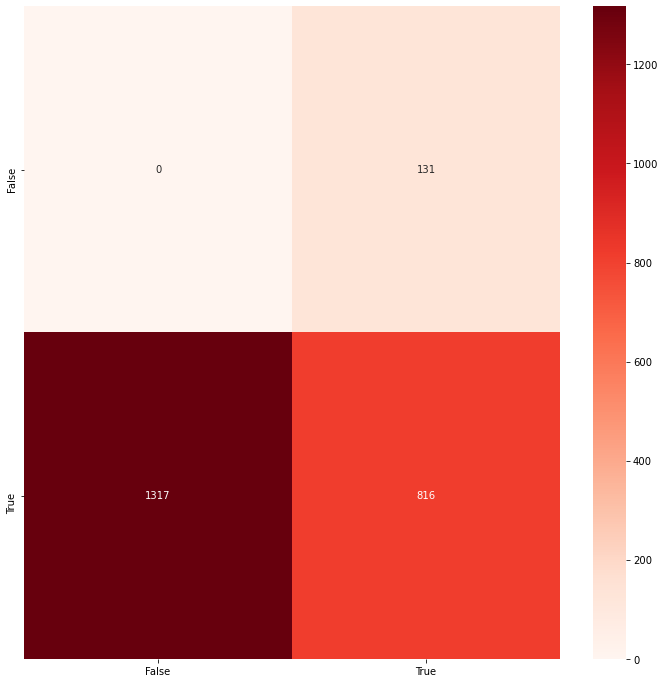

In [50]:
draw_confusion_matrix(df, 'exists')

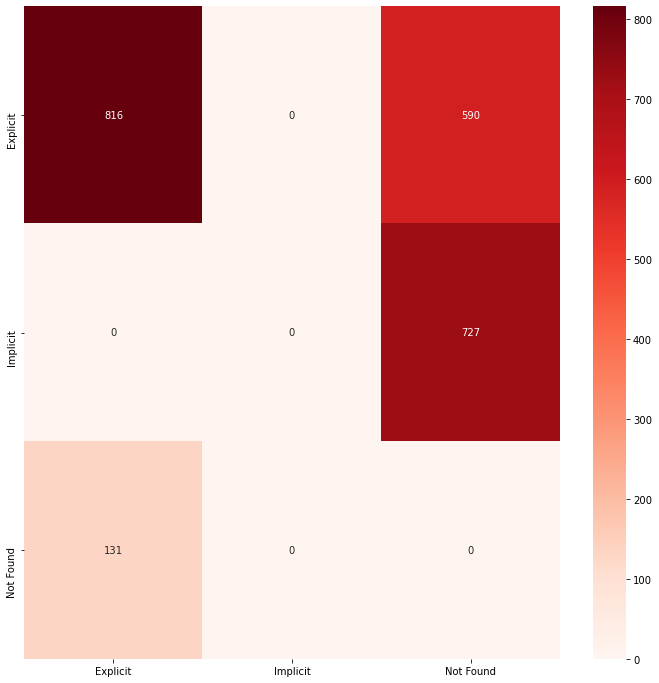

In [52]:
draw_confusion_matrix(df, 'type')

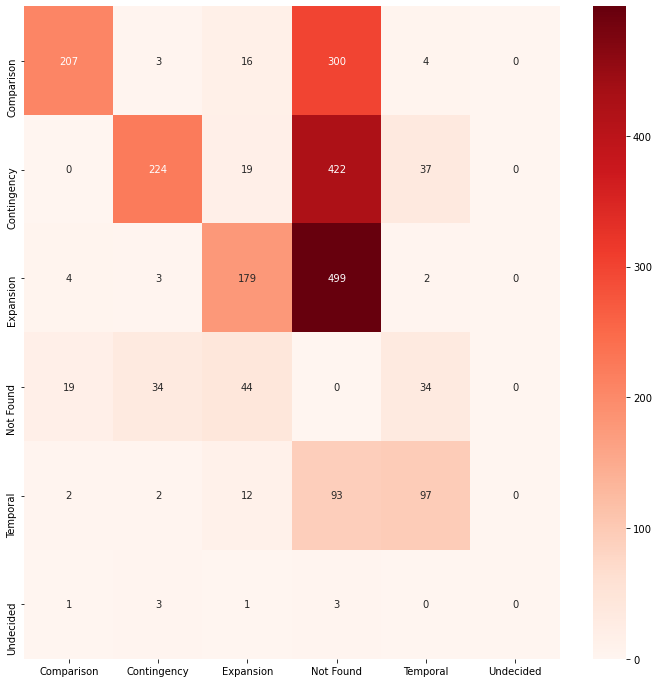

In [53]:
draw_confusion_matrix(df, 'sense_1')

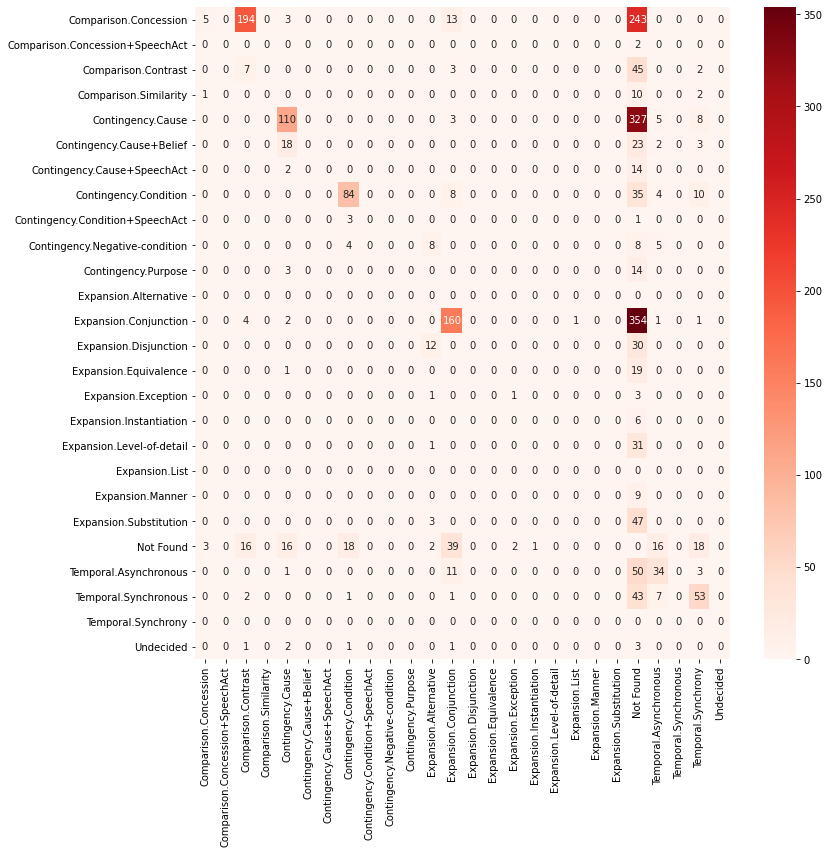

In [54]:
draw_confusion_matrix(df, 'sense_2')

In [44]:
def clean_file(file_path, file_name):
    with open(file_path + '/' + file_name, 'r', encoding='utf8') as file:
        line_offsets = list()
        file_content = file.read()
        line_breaks = [index for index, char in enumerate(list(file_content)) if char == '\n']
        new_thread = []
        for line in file_content.split('\n'):
            if (len(line) == 0):
                break
            line_pieces = line.split('\t')
            if len(line_pieces) > 1:
                handle = line_pieces[0]
                # +1 is for the tab.
                line_offset = len(handle) + 1
                line_offsets.append(line_offset)
                new_thread.append(line_pieces[1])
            else:
                new_thread.append(line)
                line_offsets.append(0)
            new_thread.append('\n')
        with open('data/tw_data/PDTB_Annotations_20200205__/ann/raw/' + file_name, 'r', encoding='utf8') as ann_file:
            ann_file_content = ann_file.read()
            new_content = []
            _start = 0
            _end = 1
            _in_number = False
            for i, ann_char  in enumerate(ann_file_content):
                if not _in_number:
                    if ann_char.isdigit():
                        _start = i
                        _in_number = True
                    else:
                        new_content.append(ann_char)
                else:
                    if not ann_char.isdigit():
                        _end = i
                        _in_number = False
                        if not ann_file_content[_start - 1].isalpha():
                            num = int(ann_file_content[_start:_end])
                            line_number = file_content.count('\n', 0, num - 1)
                            new_num = num - sum(line_offsets[:line_number + 1])
                            new_content.append(str(new_num))
                            new_content.append(ann_char)
                        _start = _end + 1
                        continue
            with open('data/tw_data/PDTB_Annotations_20200205__/cleaned/ann/' + file_name, 'w', encoding='utf8') as cleaned_ann:
                cleaned_ann.write(''.join(new_content))
            with open('data/tw_data/PDTB_Annotations_20200205__/cleaned/threads/' + file_name, 'w', encoding='utf8') as cleaned_thread:
                cleaned_thread.write(''.join(new_thread))
        
        
        